In [ ]:
#### Stage 1: Environment Setup
Here we import the python libraries we need ready to conduct the join, tranformation to validate the integrity of the dataset and make alterations where nessesary.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# For statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Path management
import os
from pathlib import Path

#### Stage 2: Load processed data
Next we load in the data and check the shape and first few rows to validate with a small sample to initially verify if it has been read correctly.

In [2]:
# Load the processed regional carbon intensity data
generation_mix = pd.read_csv(r'../data/processed/generation_mix.csv')

# Check the row and column count and preview the first 5 rows
print(f"Loaded generation mix data: {generation_mix.shape[0]:,} rows × {generation_mix.shape[1]} columns")
generation_mix.head()

Loaded generation mix data: 291,216 rows × 34 columns


,DATETIME,GAS,COAL,NUCLEAR,WIND,WIND_EMB,HYDRO,IMPORTS,BIOMASS,OTHER,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2009-01-01 00:00:00+00:00,8369.0,15037.0,7099.0,244.0,61.0,246,2519.0,0.0,0.0,...,7.5,0.0,0.0,0.0,0.0,100.0,22.8,24.5,1.6,69.7
1,2009-01-01 00:30:00+00:00,8498.0,15095.0,7088.0,225.0,56.0,245,2497.0,0.0,0.0,...,7.4,0.0,0.0,0.0,0.0,100.0,22.6,24.3,1.6,70.0
2,2009-01-01 01:00:00+00:00,8474.0,15088.0,7074.0,204.0,51.0,246,2466.0,0.0,0.0,...,7.3,0.0,0.0,0.0,0.0,100.0,22.5,24.2,1.5,70.1
3,2009-01-01 01:30:00+00:00,8319.0,15034.0,7064.0,188.0,47.0,246,2440.0,0.0,0.0,...,7.3,0.0,0.0,0.0,0.0,100.0,22.6,24.3,1.4,70.0
4,2009-01-01 02:00:00+00:00,8296.0,15004.0,7052.0,173.0,43.0,246,2364.0,0.0,0.0,...,7.1,0.0,0.0,0.0,0.0,100.0,22.6,24.3,1.4,70.2


In [4]:
# Load the processed combined carbon intensity data
combined_carbon_intensity = pd.read_csv(r'../data/processed/combined_generation_carbon_intensity.csv')

# Check the row and column count and preview the first 5 rows
print(f"Loaded generation mix data: {combined_carbon_intensity.shape[0]:,} rows × {combined_carbon_intensity.shape[1]} columns")
combined_carbon_intensity.head()

Loaded generation mix data: 121,034 rows × 48 columns


,GAS,COAL,NUCLEAR,WIND,WIND_EMB,HYDRO,IMPORTS,BIOMASS,OTHER,SOLAR,...,North Wales and Merseyside,South Wales,West Midlands,East Midlands,East England,South West England,South England,London,South East England,datetime
0,3349.0,416.0,7242.0,7962.0,2085.0,366.0,1506.0,1783.0,81.0,0.0,...,157.0,271.0,40.0,325.0,58.0,72.0,116.0,49.0,73.0,2018-09-17 23:00:00+00:00
1,3399.0,412.0,7243.0,7756.0,2120.0,359.0,1456.0,1385.0,82.0,0.0,...,183.0,157.0,39.0,340.0,61.0,90.0,152.0,69.0,70.0,2018-09-17 23:30:00+00:00
2,3116.0,389.0,7247.0,7814.0,2151.0,348.0,1506.0,1385.0,82.0,0.0,...,180.0,155.0,39.0,337.0,60.0,89.0,152.0,68.0,70.0,2018-09-18 00:00:00+00:00
3,2975.0,390.0,7247.0,7829.0,2142.0,340.0,1482.0,1553.0,82.0,0.0,...,175.0,151.0,38.0,330.0,58.0,87.0,150.0,69.0,70.0,2018-09-18 00:30:00+00:00
4,2917.0,375.0,7248.0,7706.0,2117.0,334.0,1460.0,1585.0,82.0,0.0,...,171.0,148.0,37.0,326.0,57.0,85.0,151.0,70.0,69.0,2018-09-18 01:00:00+00:00


#### Stage 3:

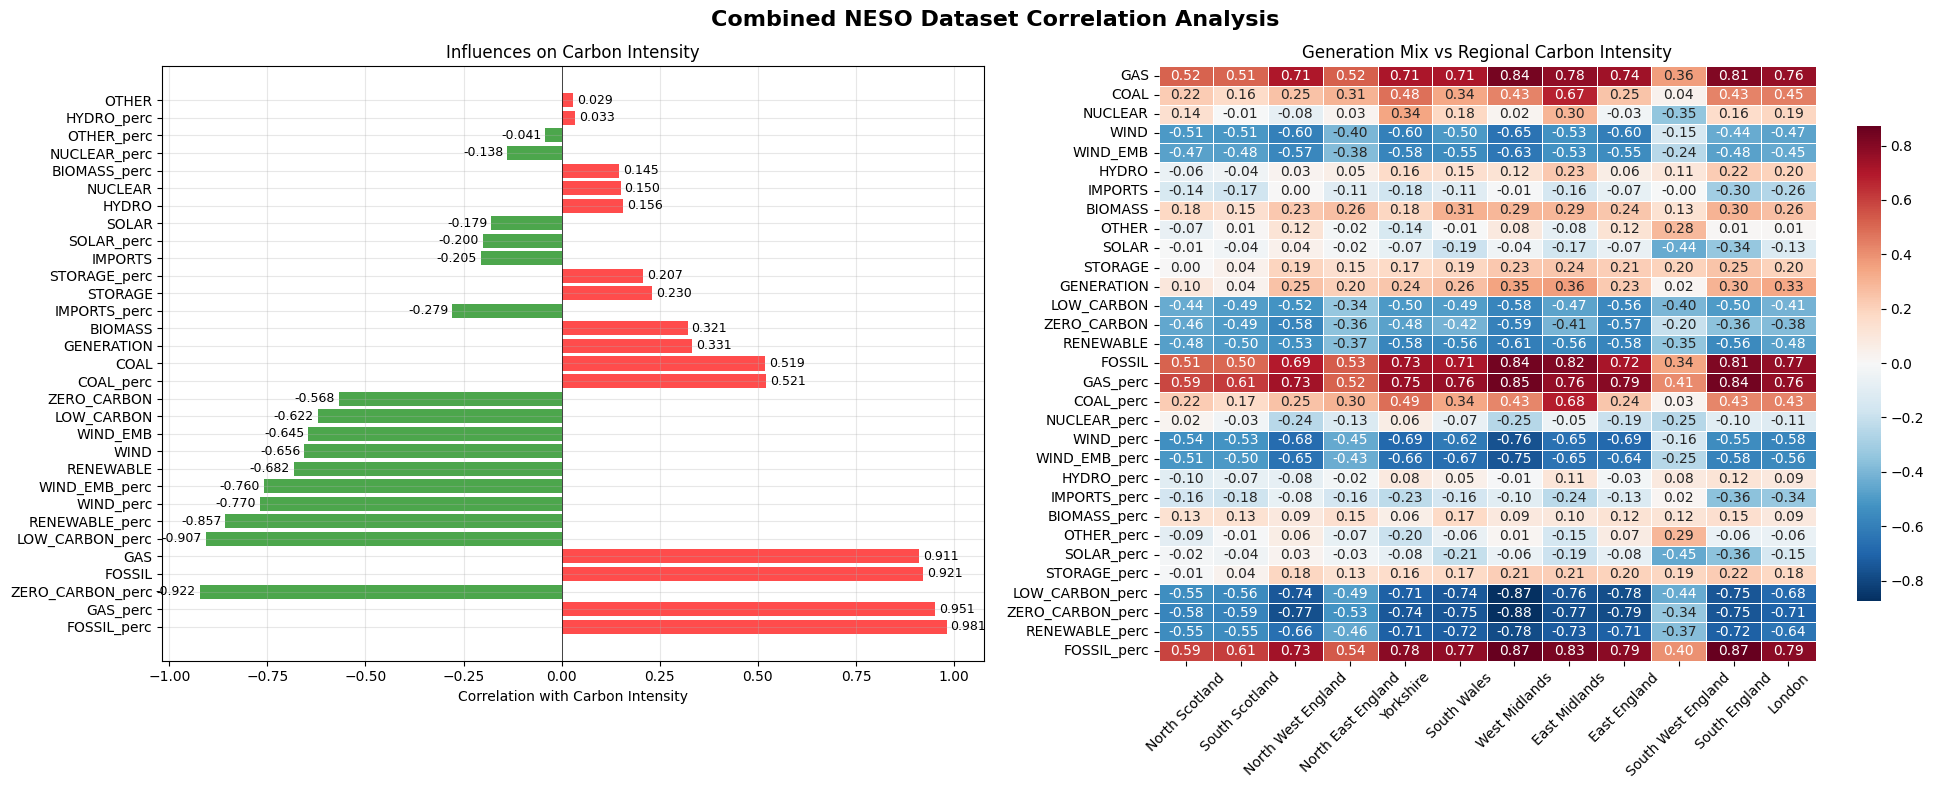

In [8]:
# Select only numeric columns for correlation analysis
numeric_cols = combined_carbon_intensity.select_dtypes(include=[np.number]).columns.tolist()

regional_cols = [col for col in numeric_cols if col in ['North Scotland', 'South Scotland', 'North West England', 'North East England', 'Yorkshire', 'North Wales', 'South Wales', 'West Midlands', 'East Midlands', 'East England', 'London', 'South England', 'South West England', 'Northern Ireland']]

# Calculate correlation matrix
correlation_matrix = combined_carbon_intensity[numeric_cols].corr()

# Create visualization
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Combined NESO Dataset Correlation Analysis', fontsize=16, fontweight='bold')

# 1. Influences on carbon intensity

# Updated generation columns to match your actual column names
gen_cols = [col for col in numeric_cols if col in [
    'GAS', 'COAL', 'NUCLEAR', 'WIND', 'WIND_EMB', 'HYDRO', 'IMPORTS', 
    'BIOMASS', 'OTHER', 'SOLAR', 'STORAGE', 'GENERATION', 
    'LOW_CARBON', 'ZERO_CARBON', 'RENEWABLE', 'FOSSIL',
    'GAS_perc', 'COAL_perc', 'NUCLEAR_perc', 'WIND_perc', 'WIND_EMB_perc', 
    'HYDRO_perc', 'IMPORTS_perc', 'BIOMASS_perc', 'OTHER_perc', 
    'SOLAR_perc', 'STORAGE_perc', 'LOW_CARBON_perc', 'ZERO_CARBON_perc', 
    'RENEWABLE_perc', 'FOSSIL_perc'
]]

influences = []
    
for col in gen_cols:
    corr = combined_carbon_intensity[col].corr(combined_carbon_intensity['CARBON_INTENSITY'])
    if not pd.isna(corr):
        influences.append((col, corr))
    
# Sort by absolute correlation strength
influences.sort(key=lambda x: abs(x[1]), reverse=True)
    
# Take all influences
fuel_types = [x[0] for x in influences]
correlations = [x[1] for x in influences]
    
# Create horizontal bar chart
colors = ['red' if corr > 0 else 'green' for corr in correlations]
bars = ax1.barh(range(len(fuel_types)), correlations, color=colors, alpha=0.7)
    
ax1.set_yticks(range(len(fuel_types)))
ax1.set_yticklabels(fuel_types)
ax1.set_xlabel('Correlation with Carbon Intensity')
ax1.set_title('Influences on Carbon Intensity')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
# Add correlation values on bars
for i, (bar, corr) in enumerate(zip(bars, correlations)):
    ax1.text(corr + (0.01 if corr > 0 else -0.01), i, f'{corr:.3f}', 
            va='center', ha='left' if corr > 0 else 'right', fontsize=9)

# 2. Generation mix vs Regional CI correlations (unchanged)
if gen_cols and regional_cols:
    cross_corr = combined_carbon_intensity[gen_cols + regional_cols].corr().loc[gen_cols, regional_cols]
    sns.heatmap(cross_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                linewidths=0.5, cbar_kws={'shrink': 0.8}, ax=ax2)
    ax2.set_title('Generation Mix vs Regional Carbon Intensity')
    ax2.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='y', rotation=0)

# Save the figure
figures_dir = "../results/figures"
plt.savefig(os.path.join(figures_dir, 'combined_NESO_dataset_correlation_analysis.png'), 
           dpi=300, bbox_inches='tight', facecolor='white')

plt.tight_layout()
plt.show()

##### Correlation Summary
The left-hand horizontal bar chart shows the correlation between the UK fuel mix and GB-wide carbon intensity. Green and red traffic-light colours are used to represent good and bad correlations in an easy-to-digest format. It is clear that the UK's large use of gas within the fuel mix means it has a very significant correlation between carbon intensity and the gas we use. It's also one of the most fluid generation methods, unlike nuclear that has a highly consistent output and therefore has a very minor effect on the carbon intensity. Coal has been fully phased out in more recent years and this has reduced its correlation strength. Solar is highly dependant on the time of day which weakens its direct correlation with carbon intensity unlike wind which is less dictated by the time of day.
The right-hand visual of the correlation matrix highlights how different generation methods have different effects on different regions, this is due to the geological location of specific generation facillities, we can see that south wales is more dependant on gas and receives essentially correlation with nuclear power generation. East england in comparison is far more correlated with nuclear power and solar and has far less dependance on gas.